# Titanic survival prediction model

I will try to make a model that predict which passengers survived the Titanic tragedy.
**Not done yet!**

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
x = "darkgrid, whitegrid, dark, white, ticks"
xx = x.split(", ")
sns.set(palette="colorblind",style=xx[1])
%matplotlib inline
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import DecisionTreeRegressor






In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**First, let's clean our data.**

In [3]:
print(train_data.info())
print("-"*40)
print(test_data.info())
print("-"*40)
#Checking for duplicates
print(len(train_data['PassengerId'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

### Take care of missing values:
We can see that the cabin column is pretty full with nulls, so i will drop him from the dataset.
I can assume that the ticket number is also pretty arbitrary and we can drop it too.

In [4]:
train_data.drop(["Cabin", "Ticket"], axis=1, inplace=True)
test_data.drop(["Cabin", "Ticket"], axis=1, inplace=True)

In [5]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

So right now we 177 missing values in the Age column and 2 missing values in the Embarked column.
I will the missing values in the Age column with the mean value of each Sex to make it accurate as i can.

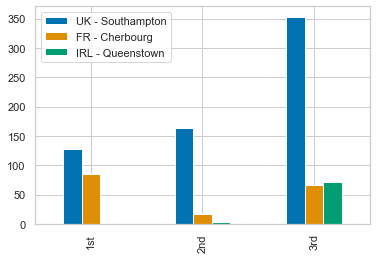

In [6]:
#checking other to transform the median by mis,mr...(title)
train_data["Age"].fillna(train_data.groupby("Sex")["Age"].transform("median"), inplace=True)
train_data[train_data["Embarked"].isnull()]

pclass1 = train_data[train_data["Pclass"] == 1]["Embarked"].value_counts()
pclass2 = train_data[train_data["Pclass"] == 2]["Embarked"].value_counts()
pclass3 = train_data[train_data["Pclass"] == 3]["Embarked"].value_counts()

pclass_df = pd.DataFrame([pclass1, pclass2, pclass3], index=["1st", "2nd", "3rd"])
x = pclass_df.plot(kind="bar")
x.legend(("UK - Southampton","FR - Cherbourg","IRL - Queenstown"))
## last place here - need to treat the embarked!

more than 50% of 1st class are from S embark
more than 50% of 2nd class are from S embark
more than 50% of 3rd class are from S embark

**fill out missing embark with S embark**

In [7]:
train_data.Embarked.fillna("S", inplace=True)

### Data exploration:
We good to go! no null values.
Lets explore some intersting connection inside our data.
Let's see how each feature effect the survival rate.

In [8]:
def bar_maker(feature, ax):
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    dead = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(30,15), ax=ax, title=feature, fontsize=20)
    ax.tick_params(labelrotation=0)
    ax.legend(fontsize=19)
    ax.set_title(feature,fontweight="bold", size=20)
  

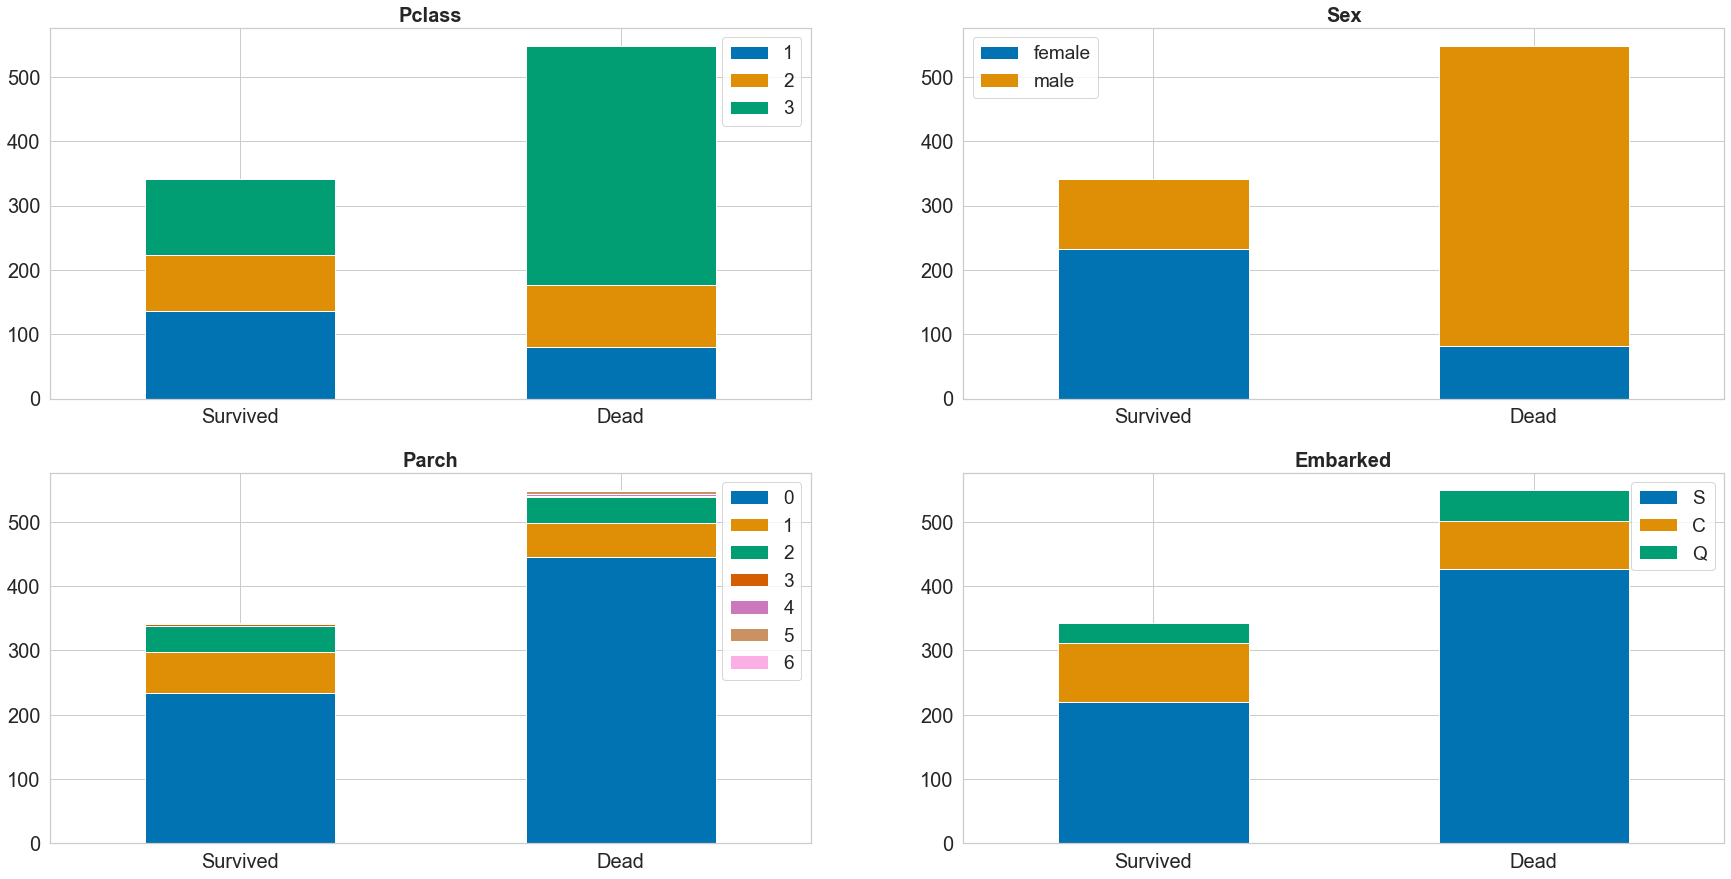

In [9]:
features = ["Pclass", "Sex", "Parch", "Embarked"]
index_plot = [[i,j] for i in [0,1] for j in [0,1]]

fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(25,15))
fig.set_figheight(30)
bar_maker(features[0], axs[0,0])
bar_maker(features[1], axs[0,1])
bar_maker(features[2], axs[1,0])
bar_maker(features[3], axs[1,1])



### Some conclusions:

#### Pclass
*   Correlation between your Pclass to the number of Deads.
    Pclass 3 is more likley to die

#### Sex
*    This feature have the greatest impact of all.
     Men survival rate is 18.8%, While woman survival rate is 74.2%

#### Parch
*    Very interesting feature - the people who was abroad by them self are more likley to be dead!

#### Embarked
*    Most of the deads got to the ship from Southhampton and Queenstownn - but i can assume that it's about the people's age
     or their Pclass.
     
     Let's check it out.


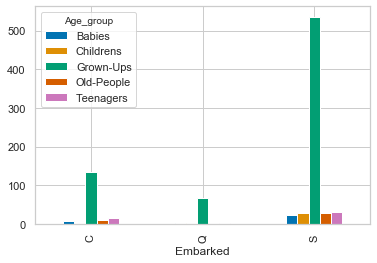

In [10]:
#Making the age mapping simpler 
train_data.loc[(train_data.Age <=3), "Age_group"] = "Babies"
train_data.loc[(train_data.Age <=10)&(train_data.Age>3), "Age_group"] = "Childrens"
train_data.loc[(train_data.Age <=17)&(train_data.Age>10), "Age_group"] = "Teenagers"
train_data.loc[(train_data.Age <=55)&(train_data.Age>17), "Age_group"] = "Grown-Ups"
train_data.loc[(train_data.Age>=55), "Age_group"] = "Old-People"

train_data.loc[train_data.Fare <=8, "Fare_group"] = 1
train_data.loc[(train_data.Fare <=15)&(train_data.Fare>8), "Fare_group"] = 2
train_data.loc[(train_data.Fare <=32)&(train_data.Fare>15), "Fare_group"] = 3
train_data.loc[(train_data.Fare>=32), "Fare_group"] = 4



pd.crosstab(train_data['Embarked'],train_data['Age_group']).plot.bar()


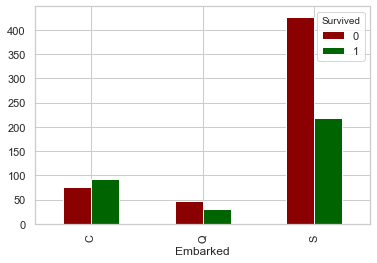

In [11]:
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
RG=LinearSegmentedColormap.from_list('rg',l, N=256)

x = train_data.groupby("Embarked")["Survived"].value_counts()
x.unstack().plot(kind="bar",colormap=RG)


The only embarked place which there is more people who survived is France.
Maybe it means that people from France were more strong? rich? not old?

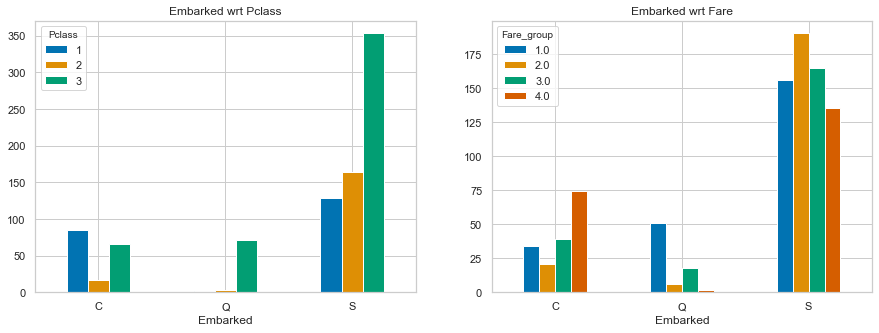

In [12]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))


train_data.groupby("Embarked")["Pclass"].value_counts().unstack().plot(kind="bar",ax=axs[0], title="Embarked wrt Pclass")
axs[0].tick_params(labelrotation=0)

train_data.groupby("Embarked")["Fare_group"].value_counts().unstack().plot(kind="bar", ax=axs[1], title="Embarked wrt Fare")
axs[1].tick_params(labelrotation=0)

Yes, probably the prople from France was more rich than all the other embarked places.
Porportioanily they pay more than any one of the others groups.
But, let's check what is the correlation between the price of the tickets and the survival rate.

Text(0.5, 1, 'Correlation between Fare and Survival rate')

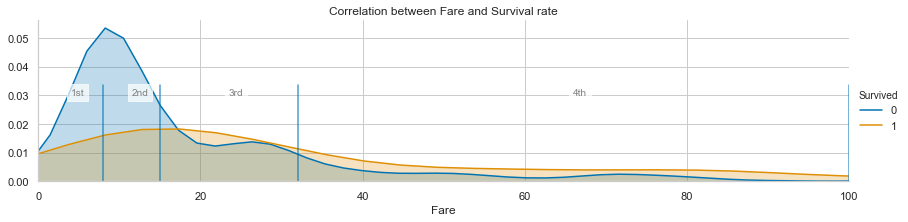

In [13]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train_data['Fare'].max()))
facet.add_legend()
plt.xlim(0,100)
style = dict(size=10, color='gray')
normalizer = 0
for k,v in {"1st":8,"2nd":15,"3rd":32,"4th":100}.items():
    plt.axvline(v, 0,0.60, alpha=0.7)
    plt.text(((v-normalizer)/2)+normalizer, 0.03, k, **style, bbox=dict(facecolor='white', alpha=0.7))
    normalizer=v
plt.title("Correlation between Fare and Survival rate")





As I expected, there is a correlation!


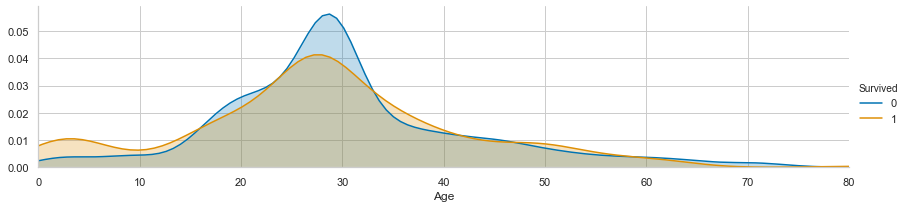

In [14]:

facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()
 
plt.show()

Before we will start the model of prediction, i will make all the paramters in the dataset to floats/int.

In [15]:
train_data.select_dtypes(include="object").columns

Index(['Name', 'Sex', 'Embarked', 'Age_group'], dtype='object')

In [16]:

sex_mapping = {"male":0, "female":1}
train_data.Sex = train_data["Sex"].map(sex_mapping)

embarked_mapping = {"S":0, "C":1,"Q":2}
train_data.Embarked = train_data["Embarked"].map(embarked_mapping)


# train_data.loc[(train_data.Embarked == "S"), "Embarked"] = 1
# train_data.loc[(train_data.Embarked == "C"), "Embarked"] = 2
# train_data.loc[(train_data.Embarked == "Q"), "Embarked"] = 3

In [17]:
train_data.drop("Age_group",axis=1, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
 10  Fare_group   891 non-null    float64
dtypes: float64(3), int64(7), object(1)
memory usage: 76.7+ KB


In [18]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_data.Title.value_counts()
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2}
train_data.Title = train_data["Title"].map(title_mapping)

title_series = pd.to_numeric(train_data.Title, errors='coerce')
title_series.fillna(value=3, inplace=True)
train_data.Title = title_series

train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
Fare_group     float64
Title          float64
dtype: object

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
X = train_data.drop(["Survived", "Name"], axis=1)
y = train_data[["Survived"]]
train_X, val_X, train_y, val_y = train_test_split(X,y, random_state=1)
model = DecisionTreeRegressor(random_state=1)
model.fit(train_X, train_y)

predictions = model.predict(val_X)
mean_absolute_error(val_y, predictions)


0.273542600896861

In [20]:
iris = sns.load_dataset("iris")
iris.head()
X_iris = iris.drop(columns="species")
y_iris = iris.species

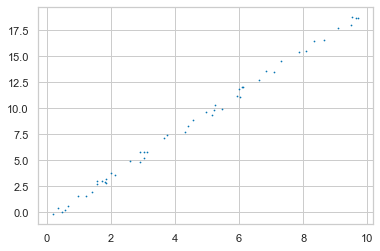

In [21]:
rng = np.random.RandomState(42)
x = 10*rng.rand(50)
y= 2*x-1+rng.rand(50)

plt.scatter(x,y,s=0.5)

In [22]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

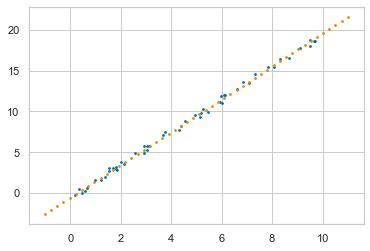

In [23]:
X = x[:,np.newaxis]
model.fit(X,y)
xfit = np.linspace(-1, 11)
Xfit = xfit[:,np.newaxis]
yfit = model.predict(Xfit)
plt.scatter(x,y,s = 3)
plt.scatter(xfit, yfit,s=3 )